In [1]:
# HIDDEN
using CSV
using DataFrames
using MLBase
using MLJ
using Statistics
using StatsBase
using StatsPlots
Base.displaysize() = (5, 90)

In [2]:
# HIDDEN
emails = CSV.read("selected_emails.csv")
emails = select(emails, Not(:Column1));

## Evaluating Logistic Models

Although we used the classification accuracy to evaluate our logistic model in previous sections, using the accuracy alone has some serious flaws that we explore in this section. To address these issues, we introduce a more useful metric to evaluate classifier performance: the **Area Under Curve (AUC)** metric.

Suppose we have a dataset of 1000 emails that are labeled as spam or ham (not spam) and our goal is to build a classifier that distinguishes future spam emails from ham emails. The data is contained in the `emails` DataFrame, and we display the first row below:

In [4]:
first(emails)

,body
,String
1,"\n Hi Folks,\n \n I've been trying to set a button called which automatically\n forwards mail using a '-form mycomps' without going through\n the editor, but so far haven't got the right recipe.\n \n I currently have in my .exmh-defaults:\n \n *Mops.spam.text: Spam\n *Mops.spam.command: Msg_Forward -form spamcomps -noedit -nowhatnowproc ; Msg\n _Remove\n \n \n I've also tried with ""SeditSend {$draft $t 0}"" after the forward command.\n It should forward to a spam address (where filters get adjusted) and then\n delete. It does so, but not without producing the edit window.\n \n Any help appreciated.\n \n Wendy Roberts\n \n \n \n ===========================================\n Wendy Roberts \n HEAD System Administrator \n High Energy Astrophsics Division\n Harvard-Smithsonian Center for Astrophysics\n Cambridge, MA USA 02138\n wendy@cfa.harvard.edu \n Phone: 617-495-7153 \n ===========================================\n \n \n \n _______________________________________________\n Exmh-users mailing list\n Exmh-users@redhat.com\n https://listman.redhat.com/mailman/listinfo/exmh-users\n \n \n"


Each row contains the body of an email in the `body` column and a spam indicator in the `spam` column, which is `0` if the email is ham or `1` if it is spam.

Let's compare the performance of three different classifiers:
* `ham_only`: labels every email as ham.
* `spam_only`: labels every email as spam.
* `words_list_model`: predicts 'ham' or 'spam' based on the presence of certain words in the body of an email.

Suppose we have a list of words `words_list` that we believe are common in spam emails: "please", "click", "money", "business", and "remove". We construct `words_list_model` using the following procedure: transform each email into a feature vector by setting the vector's $i$th entry to 1 if the $i$th word in `words_list` is contained in the email body and 0 if it isn't. For example, using our five chosen words and the email body "please remove by tomorrow", the feature vector would be $[1, 0, 0, 0, 1]$. This procedure generates the `1000 X 5` feature matrix $\textbf{X}$.

The following code block displays the accuracies of the classifiers. Model creation and training are omitted for brevity.

In [318]:
# HIDDEN
using Printf

function words_in_text(words_list, text_array)
    indicator_df = DataFrame([i=Float64[] for i in words_list], [Symbol(i) for i in words_list])
    for text in text_array
        push!(indicator_df, Float64.(occursin.(words_list, text)))
    end
    return indicator_df
end;

#@load LogisticClassifier pkg=ScikitLearn

In [44]:
# HIDDEN
words_list = ["please", "click", "money", "business", "remove"]
X = words_in_text(words_list, emails.body)
y = coerce(emails.spam, Multiclass)

train, test = partition(eachindex(y), 0.75, shuffle=true)

lc = LogisticClassifier()

lc_machine = machine(lc, X, y)
fit!(lc_machine, rows=train, verbosity=0)

y_prediction_words_list = predict(lc_machine, rows=test)
converted_predictions = [i >= 0.5 ? 1 : 0 for i in pdf.(y_prediction_words_list, 1)];

In [62]:
# Our selected words
words_list = ["please", "click", "money", "business", "remove"]

@printf("ham_only test set accuracy: %0.3f \n", countmap(y[test])[0]/length(test))
@printf("spam_only test set accuracy: %0.3f \n", countmap(y[test])[1]/length(test))
@printf("spam_only test set accuracy: %0.3f \n", sum(converted_predictions .== y[test])/length(test))

ham_only test set accuracy: 0.956 
spam_only test set accuracy: 0.044 
spam_only test set accuracy: 0.956 


Using `words_list_model` classifies 96% of the test set emails correctly. Although this accuracy appears high, `ham_only` achieves the same accuracy by simply labeling everything as ham. This is cause for concern because the data suggests we can do just as well without a spam filter at all.

As the accuracies above show, model accuracy alone can be a misleading indicator of model performance. We can understand the model's predictions in greater depth using a **confusion matrix**. A confusion matrix for a binary classifier is a two-by-two heatmap that contains the model predictions on one axis and the actual labels on the other.

Each entry in a confusion matrix represents a possible outcome of the classifier. If a spam email is input to the classifier, there are two possible outcomes:
* **True Positive** (top left entry): the model correctly labels it with the positive class (spam).
* **False Negative** (top right entry): the model mislabels it with the negative class (ham), but it truly belongs in the positive class (spam). In our case, a false negative means that a spam email gets mislabelled as ham and ends up in the inbox.

Similarly, if a ham email is input to the classifier, there are two possible outcomes.
* **False Positive** (bottom left entry): the model mislabels it with the positive class (spam), but it truly belongs in the negative class (ham). In our case, a false positive means that a ham email gets flagged as spam and filtered out of the inbox.
* **True Negative** (bottom right entry): the model correctly labels it with the negative class (ham).

The costs of false positives and false negatives depend on the situation. For email classification, false positives result in important emails being filtered out, so they are worse than false negatives, in which a spam email winds up in the inbox. In medical settings, however, false negatives in a diagnostic test can be much more consequential than false positives.

We will use `MLBase`'s [`confusmat`](https://github.com/JuliaStats/MLBase.jl/blob/master/docs/source/perfeval.rst) function to construct confusion matrices for the three models on the training data set. 

We define a convenience function `plot_confusion_matrix` to plot a heatmap of the constructed confusion matrices. The `ham_only` confusion matrix is shown below:

In [168]:
# HIDDEN
function plot_confusion_matrix(ground_truth, predictions, labels; title="Confusion Matrix")
    confusion_matrix = confusmat(length(labels), ground_truth .+1, predictions .+1)
    h = heatmap(labels, labels, confusion_matrix, c=:dense)
    for i in 1:length(labels)
        for j in 1:length(labels)
            annotate!([(i-0.5, j-0.5, Plots.text(string(confusion_matrix[i,j])))])
        end
    end
    title!(title)
    xlabel!("True label")
    ylabel!("Predicted label")
    h
end;

In [181]:
# HIDDEN
y_train = emails.spam[train];
ham_only = Int.(zeros(length(train)))
spam_only = Int.(ones(length(train)))

y_train_prediction_words_list = predict(lc_machine, rows=train)
converted_predictions_train = [i >= 0.5 ? 1 : 0 for i in pdf.(y_train_prediction_words_list, 1)];

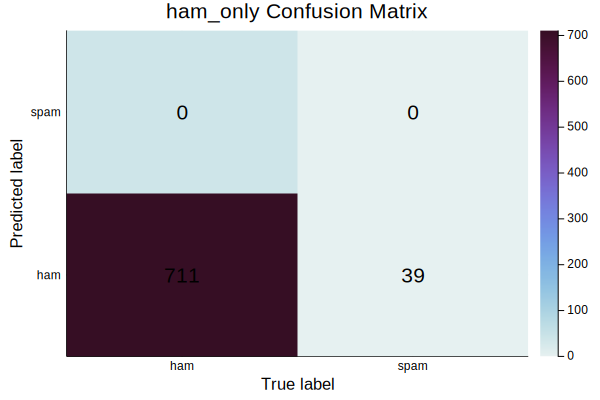

In [182]:
class_names = ["ham", "spam"]

plot_confusion_matrix(y_heat, ham_only, class_names;
    title="ham_only Confusion Matrix")

Summing the quantities in a row indicates how many emails in the training dataset belong to the corresponding class:
* True label = ham (first row): the sum of false positives (0) and true negatives (711) reveals there are 711 ham emails in the training dataset.
* True label = spam (second row): the sum of true positives (0) and false negatives (39) reveals there are 39 spam emails in the training dataset.

Summing the quantities in a column indicates how many emails the classifier predicted in the corresponding class:
* Predicted label = spam (second column): the sum of true positives (0) and false positives (0) reveals `ham_only` predicted there are 0 spam emails in the training dataset.
* Predicted label = ham (first column): the sum of false negatives (39) and true negatives (711) reveals `ham_only` predicted there are 750 ham emails in the training dataset.

We can see that `ham_only` had a high accuracy of $\left(\frac{711}{750} \approx .95\right)$ because there are 711 ham emails in the training dataset out of 750 total emails.

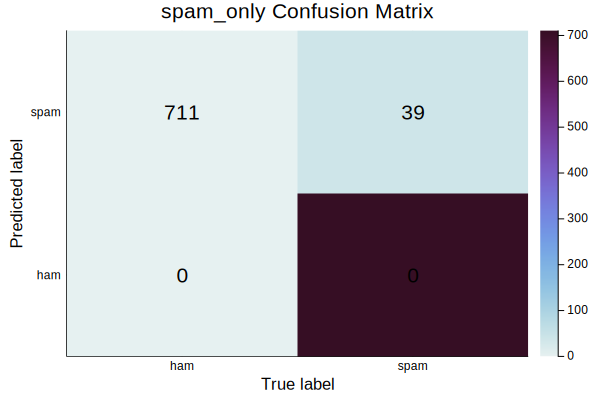

In [184]:
plot_confusion_matrix(y_heat, spam_only, class_names;
    title="spam_only Confusion Matrix")

At the other extreme, `spam_only` predicts the training dataset has no ham emails, which the confusion matrix indicates is far from the truth with 758 false positives.

Our main interest is the confusion matrix for `words_list_model`:

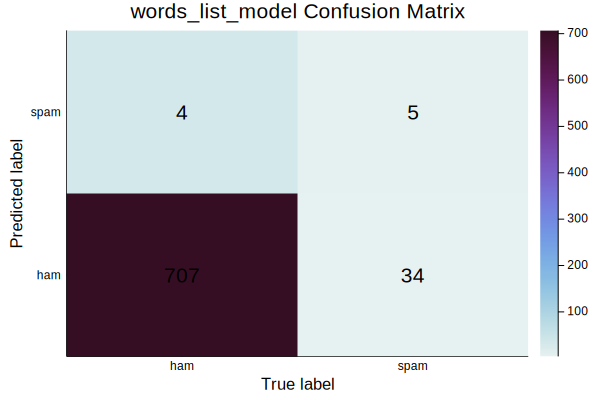

In [185]:
plot_confusion_matrix(y_heat, converted_predictions_train, class_names;
    title="words_list_model Confusion Matrix")

The row totals match those of the `ham_only` and `spam_only` confusion matrices as expected since the true labels in the training dataset are unaltered for all models.

Of the 39 spam emails, `words_list_model` correctly classifies 5 of them, which is a poor performance. Its high accuracy is buoyed by the large number of true negatives, but this is insufficient because it does not serve its purpose of reliably filtering out spam emails.

This emails dataset is an example of a **class-imbalanced dataset**, in which a vast majority of labels belong to one class over the other. In this case, most of our emails are ham. Another common example of class imbalance is disease detection when the frequency of the disease in a population is low. A medical test that always concludes a patient doesn't have the disease will have a high accuracy because most patients truly won't have the disease, but its inability to identify individuals with the disease renders it useless. 

We now turn to sensitivity and specificity, two metrics that are better suited for evaluating class-imbalanced datasets.

### Sensitivity

**Sensitivity** (also called **true positive rate**) measures the proportion of data belonging to the positive class that the classifier correctly labels.

$$ \text{Sensitivity} = \frac{TP}{TP + FN} $$

From our discussion of confusion matrices, you should recognize the expression $TP + FN$ as the sum of the entries in the first row, which is equal to the actual number of data points belonging to the positive class in the dataset. Using confusion matrices allows us to easily compare the sensitivities of our models:

* `ham_only`: $\frac{0}{0 + 39} = 0$
* `spam_only`: $\frac{39}{39 + 0} = 1$
* `words_list_model`: $\frac{5}{34 + 5} \approx .128$

Since `ham_only` has no true positives, it has the worst possible sensitivity value of 0. On the other hand, `spam_only` has an abysmally low accuracy but it has the best possible sensitivity value of 1 because it labels all spam emails correctly. The low sensitivity of `words_list_model` indicates that it frequently fails to mark spam emails as such; nevertheless, it significantly outperforms `ham_only`.

### Specificity

**Specificity** (also called **true negative rate**) measures the proportion of data belonging to the negative class that the classifier correctly labels.

$$ \text{Specificity} = \frac{TN}{TN + FP} $$ 

The expression $TN + FP$ is equal to the actual number of data points belonging to the negative class in the dataset. Again the confusion matrices help to compare the specificities of our models:

* `ham_only`: $\frac{711}{711 + 0} = 1$
* `spam_only`: $\frac{0}{0 + 711} = 0$
* `words_list_model`: $\frac{707}{707 + 34} \approx .954$

As with sensitivity, the worst and best specificities are 0 and 1 respectively. Notice that `ham_only` has the best specificity and worst sensitivity, while `spam_only` has the worst specificity and best sensitivity. Since these models only predict one label, they will misclassify all instances of the other label, which is reflected in the extreme sensitivity and specificity values. The disparity is much smaller for `words_list_model`. 

Although sensitivity and specificity seem to describe different characteristics of a classifier, we draw an important connection between these two metrics using the classification threshold.

### Classification Threshold

The **classification threshold** is a value that determines what class a data point is assigned to; points that fall on opposite sides of the threshold are labeled with different classes. Recall that logistic regression outputs a probability that the data point belongs to the positive class. If this probability is greater than the threshold, the data point is labeled with the positive class, and if it is below the threshold, the data point is labeled with the negative class. For our case, let $f_{\hat{\theta}}$ be the logistic model and $C$ the threshold. If $f_{\hat{\theta}}(x) > C$, $x$ is labeled spam; if $f_{\hat{\theta}}(x) < C$, $x$ is labeled ham. Scikit-learn breaks ties by defaulting to the negative class, so if $f_{\hat{\theta}}(x) = C$, $x$ is labeled ham.

We can assess our model's performance with classification threshold $C$ by creating a confusion matrix. The `words_list_model` confusion matrix displayed earlier in the section uses the default threshold $C = .50$. 

Raising the threshold to $C = .70$, meaning we label an email $x$ as spam if the probability $f_{\hat{\theta}}(x)$ is greater than .70, results in the following confusion matrix:

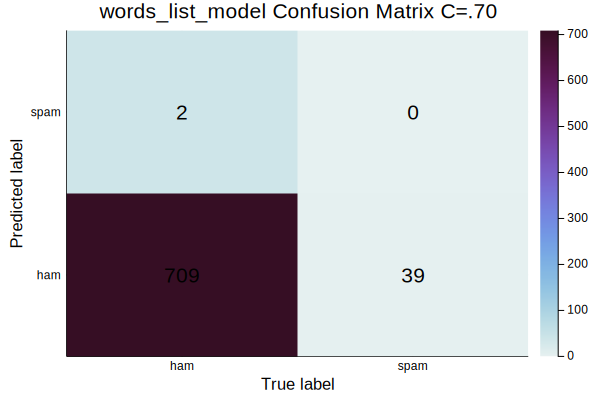

In [187]:
# HIDDEN
converted_predictions_high_th = [i >= 0.7 ? 1 : 0 for i in pdf.(y_train_prediction_words_list, 1)]
plot_confusion_matrix(y_heat, converted_predictions_high_th, class_names;
    title="words_list_model Confusion Matrix C=.70")

By raising the bar for classifying an email as spam, 5 spam emails that were correctly classified with $C = .50$ are now mislabeled. 

$$ \text{Sensitivity } (C = .70) = \frac{0}{39} = 0 \\
\text{Specificity } (C = .70) = \frac{709}{711} \approx .997
$$

Compared to the default, a higher threshold of $C = .70$ increases specificity but decreases sensitivity.

Lowering the threshold to $C = .30$, meaning we label an email $x$ as spam if the probability $f_{\hat{\theta}}(x)$ is greater than .30, results in the following confusion matrix:

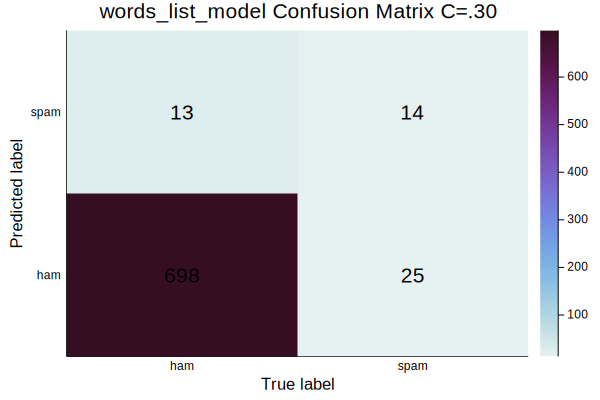

In [188]:
# HIDDEN
converted_predictions_low_th = [i >= 0.3 ? 1 : 0 for i in pdf.(y_train_prediction_words_list, 1)]
plot_confusion_matrix(y_heat, converted_predictions_low_th, class_names;
    title="words_list_model Confusion Matrix C=.30")

By lowering the bar for classifying an email as spam, 9 spam emails that were mislabeled with $C = .50$ are now correct. However, there are more false positives.

$$ \text{Sensitivity } (C = .30) = \frac{14}{39} \approx .482 \\
\text{Specificity } (C = .30) = \frac{698}{711} \approx .981
$$

Compared to the default, a lower threshold of $C = .30$ increases sensitivity but decreases specificity.

We adjust a model's sensitivity and specificity by changing the classification threshold. Although we strive to maximize both sensitivity and specificity, we can see from the confusion matrices created with varying classification thresholds that there is a tradeoff. Increasing sensitivity leads to a decrease in specificity and vice versa.

### ROC Curves

We can calculate sensitivity and specificity values for all classification thresholds between 0 and 1 and plot them. Each threshold value $C$ is associated with a (sensitivity, specificity) pair. A **ROC (Receiver Operating Characteristic) curve** is a slight modification of this idea; instead of plotting (sensitivity, specificity) it plots (sensitivity, 1 - specificity) pairs, where 1 - specificity is defined as the false positive rate.

$$ \text{False Positive Rate } = 1 - \frac{TN}{TN + FP} = \frac{TN + FP - TN}{TN + FP} = \frac{FP}{TN + FP} $$

A point on the ROC curve represents the sensitivity and false positive rate associated with a specific threshold value. 

The ROC curve for `words_list_model` is calculated below using `MLBase`[`roc`](https://mlbasejl.readthedocs.io/en/latest/perfeval.html#receiver-operating-characteristics-roc) function.

In [293]:
# Obtain preditions on training set
y_train_prediction_words_list = predict(lc_machine, rows=train)

# Convert prediction for C=.50
y_train_converted_predictions = [i >= 0.5 ? 1 : 0 for i in pdf.(y_train_prediction_words_list, 1)]

# Obtain ROC curve values
roc_curve = MLBase.roc(y_heat, scores, 1000);

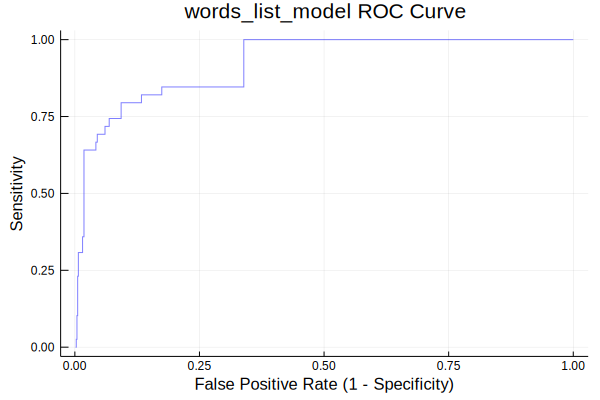

In [294]:
# HIDDEN
xs = [curve.fp / (curve.tn + curve.fp) for curve in roc_curve]
ys = [curve.tp / (curve.tp + curve.fn) for curve in roc_curve]

plot(xs, ys, seriestype=:steppost, legend=false, linecolor=:blue, linealpha=0.5)
title!("words_list_model ROC Curve")
xlabel!("False Positive Rate (1 - Specificity)")
ylabel!("Sensitivity")

Notice that as we move from left to right across the curve, sensitivity increases and the specificity decreases. Generally, the best classification threshold corresponds to high sensitivity and specificity (low false positive rate), so points in or around the northwest corner of the plot are preferable. 

Let's examine the four corners of the plot:
* (0, 0): Specificity $=1$, which means all data points in the negative class are correctly labeled, but sensitivity $= 0$, so the model has no true positives. (0,0) maps to the classification threshold $C = 1.0$, which has the same effect as `ham_only` since no email can have a probability greater than $1.0$.
* (1, 1): Specificity $=0$, which means the model has no true negatives, but sensitivity $= 1$, so all data points in the positive class are correctly labeled. (1,1) maps to the classification threshold $C = 0.0$, which has the same effect as `spam_only` since no email can have a probability lower than $0.0$.
* (0, 1): Both specificity $=1$ and sensitivity $= 1$, which means there are no false positives or false negatives. A model with an ROC curve containing (0, 1) has a $C$ value at which it is a perfect classifier!
* (1, 0): Both specificity $=0$ and sensitivity $= 0$, which means there are no true positives or true negatives. A model with an ROC curve containing (1, 0) has a $C$ value at which it predicts the wrong class for every data point!

A classifier that randomly predicts classes has a diagonal ROC curve containing all points where sensitivity and the false positive rate are equal:

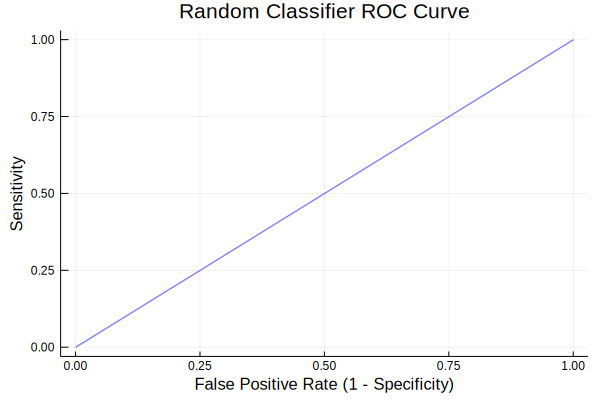

In [295]:
# HIDDEN
plot(collect(0:0.001:1.0), collect(0:0.001:1.0), seriestype=:steppost, legend=false,
    linecolor=:blue, linealpha=0.5)
title!("Random Classifier ROC Curve")
xlabel!("False Positive Rate (1 - Specificity)")
ylabel!("Sensitivity")

Intuitively, a random classifier that predicts probability $p$ for input $x$ will result in either a true positive or false positive with chance $p$, so sensitivity and the false positive rate are equal. 

We want our classifier's ROC curve to be high above the random model diagnoal line, which brings us to the AUC metric.

### AUC

The **Area Under Curve (AUC)** is the area under the ROC curve and serves as a single number performance summary of the classifier. The AUC for `words_list_model` is shaded below and calculating using [ROCAnalysis](https://github.com/davidavdav/ROCAnalysis.jl):

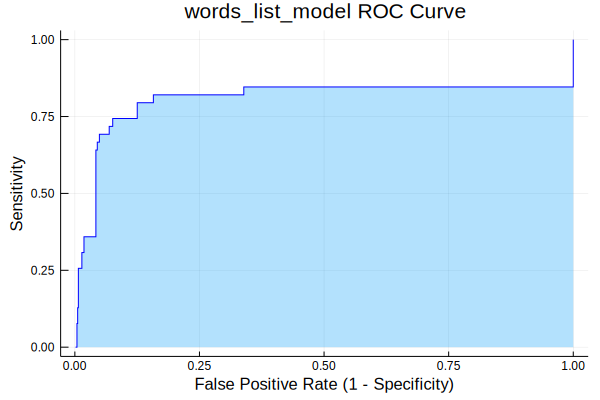

In [296]:
plot(xs, ys, seriestype=:steppre, legend=false, linecolor=:blue, fillrange=0, fillalpha=0.3)
title!("words_list_model ROC Curve")
xlabel!("False Positive Rate (1 - Specificity)")
ylabel!("Sensitivity")

In [316]:
# HIDDEN
using ROCAnalysis
r = ROCAnalysis.roc(y_heat, y_train_converted_predictions, collapse=false)
ROCAnalysis.AUC(r)

0.52

AUC is interpreted as the probability that the classifier will assign a higher probability to a randomly chosen data point truly belonging to the positive class than a randomly chosen data point truly belonging to the negative class. A perfect AUC value of 1 corresponds to a perfect classifier (the ROC curve would contain (0, 1). The fact that `words_list_model` has an AUC of .52 means that roughly 52% of the time it is more likely to classify a spam email as spam than a ham email as spam.

By inspection, the AUC of the random classifier is 0.5, though this can vary slightly due to the randomness. An effective model will have an AUC much higher than 0.5. If a model's AUC is less than 0.5, it performs worse than random predictions.

### Summary

AUC is an essential metric for evaluating models on class-imbalanced datasets. After training a model, it is best practice to generate an ROC curve and calculate AUC to determine the next step. If the AUC is sufficiently high, use the ROC curve to identify the best classification threshold. However, if the AUC is not satisfactory, consider doing further EDA and feature selection to improve the model.